In [265]:
# pip install shap

In [266]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import sys

# import utility functions for the World Bank and OECD
sys.path.append("../utility_functions")
from world_bank_oecd_utility_functions import (
    get_indicator_name_from_code,
    get_indicator_definition_or_additional_info_from_code,
)

# df_MMRT = pd.read_csv('WorldBankDatasets/Cleaned/AllMerged_Threshold_85_n3_MMRT.csv')

df_MMRTNE = pd.read_csv(
    "../WorldBankDatasets/Cleaned/AllMerged_Threshold_85_n3_MMRTNE.csv"
)
df_OECD = pd.read_csv("../OECD/Cleaned/HEALTH_MERGED_Threshold_80_n3.csv")

In [267]:
mapping_oecd_to_names_and_additional_info_df = pd.read_csv(
    "../OECD/Cleaned/OECD_Indicator_Definition_Info.csv", delimiter=","
)
mapping_world_bank_to_names_and_definitions_df = pd.read_csv(
    "../WorldBankDatasets/Cleaned/World_Bank_Indicator_Definition_Info.csv",
    delimiter="\t",
)

In [268]:
# uncomment to test OECD mapping df
# mapping_oecd_to_names_and_additional_info_df

In [269]:
# uncomment to test World Bank mapping df
# mapping_world_bank_to_names_and_definitions_df

In [270]:
# uncomment code in this block to test utility functions with the mapping dataframes

# mapping_df1 = mapping_oecd_to_names_and_additional_info_df
# mapping_df2 = mapping_world_bank_to_names_and_definitions_df

# test_code = 'ADMRASTH_M_TOTAL_15_AS_STD_RATE_MPOP'
# test_code2 = 'SH.ANM.NPRG.ZS'
# test_output1 = get_indicator_name_from_code(test_code, mapping_df1)
# # test_output1
# test_output2 = get_indicator_name_from_code(test_code2, mapping_df2)
# # test_output2
# print(test_output1)
# print(test_output2)

In [271]:
######  select which df to use

df = df_MMRTNE
indicator_y = "SH.STA.MMRT.NE"

# df = df_MMRT
# indicator_y = 'SH.STA.MMRT'

# df = df_OECD
# indicator_y = 'MATIMATM'

# Perform hyper parameter tuning?
perform_hp_tuning = False

## Simple Linear Regression

In [272]:
# First need to encode the country

# Create a LabelEncoder instance for each categorical column
country_encoder = LabelEncoder()

# Encode the categorical columns
data_encoded = df.copy(deep=True)
data_encoded["Country"] = country_encoder.fit_transform(data_encoded["Country"])

In [273]:
# pull out Maternal Mortality as the predictor variable
X = data_encoded.drop(columns=indicator_y)
y = data_encoded[indicator_y]

### 5 fold cross validation 

In [274]:
def five_fold_cv(model):
    # Create a list to store the mean squared errors (MSE) for each fold
    mse_scores = []
    r2_scores = []

    # initialize the best r2 score as 0
    best_r2_score = -100000
    best_model = None

    # Create a KFold cross-validator with 5 folds
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Perform 5-fold cross-validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]

        # Train the model on the training data
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Calculate the mean squared error (MSE) for this fold
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)
        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)

        # Keep the best model based on r2 score
        if r2 > best_r2_score:
            # Save the best r2 score and best model
            best_r2_score = r2
            best_model = model
            # Save the respective train test split
            X_train_best = X_train
            X_test_best = X_test
            y_train_best = y_train
            y_test_best = y_test

    # Calculate the mean and standard deviation of the MSE scores and r2 scores
    mean_mse = np.mean(mse_scores)
    std_mse = np.std(mse_scores)
    mean_r2 = np.mean(r2_scores)
    std_r2 = np.std(r2_scores)

    print(f"Best R-squared (R2): {best_r2_score}")
    print(f"Mean R-squared (R2): {mean_r2}")
    print(f"Standard Deviation of R-squared (R2): {std_r2}")
    print(f"Average Mean Squared Error (MSE): {mean_mse}")
    print(f"Standard Deviation of Mean Squared Error (MSE): {std_mse}")

    return best_model, X_train_best, X_test_best, y_train_best, y_test_best

In [275]:
# Establish a linear regression model
model = LinearRegression()

# Run five-fold CV
best_linear_regression, X_train, X_test, y_train, y_test = five_fold_cv(model)

Best R-squared (R2): 0.48232666394794654
Mean R-squared (R2): 0.16134496600909992
Standard Deviation of R-squared (R2): 0.36825432102276584
Average Mean Squared Error (MSE): 269.2960704536373
Standard Deviation of Mean Squared Error (MSE): 180.22335313817328


## Including Lasso Regression and Hyper-parameter Tuning

In [276]:
if perform_hp_tuning:
    # Create a Lasso regression model
    lasso_model = Lasso()

    # Define a range of alpha values to tune
    alpha_values = [
        0.01,
        0.02,
        0.03,
        0.04,
        0.05,
        0.06,
        0.07,
        0.08,
        0.09,
        0.1,
        0.2,
        0.3,
        0.4,
        0.5,
        0.6,
        0.7,
        0.8,
        0.9,
        1.0,
        2.0,
        3.0,
        4.0,
        5.0,
        6.0,
        7.0,
        8.0,
        9.0,
        10.0,
    ]

    # Create a parameter grid for GridSearchCV
    param_grid = {"alpha": alpha_values}

    # Create a GridSearchCV object with cross-validation
    grid_search = GridSearchCV(lasso_model, param_grid, cv=5)

    # Fit the grid search to the data
    grid_search.fit(X, y)

    # Get the best alpha value
    best_alpha = grid_search.best_params_["alpha"]
    print(best_alpha)

    # Get the best Lasso model
    best_lasso_model = grid_search.best_estimator_

else:
    if indicator_y == "MATIMATM":
        best_alpha = 0.2  # value found in hyperparameter tuning for OECD
    elif indicator_y == "SH.STA.MMRT.NE":
        best_alpha = 0.02  # value found in hyperparameter tuning for World Bank

In [277]:
# Establish Lasso model
lasso_model = Lasso(alpha=best_alpha)
# Run five-fold CV
best_lasso_model, X_train, X_test, y_train, y_test = five_fold_cv(lasso_model)

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.641e+01, tolerance: 3.056e+01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.256e+01, tolerance: 2.985e+01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.195e+02, tolerance: 2.688e+01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.092e+02, tolerance: 2.877e+01


Best R-squared (R2): 0.8046912892203323
Mean R-squared (R2): 0.7960103917256535
Standard Deviation of R-squared (R2): 0.008871022069466874
Average Mean Squared Error (MSE): 62.73361551022524
Standard Deviation of Mean Squared Error (MSE): 17.09710738513901


### A look into model performance for Lasso model

In [278]:
def plot_linear_reg(X, y, yp, country, title):
    # X - X_test
    # y - y_test
    # yp - y_pred
    # country - list of country abbreviations ie. ['USA']

    if country == None:
        # Plot the data points and the regression line
        plt.figure(figsize=(30, 20))
        plt.scatter(X["Year"], y, color="blue", label="Data")
        plt.scatter(X["Year"], yp, color="red", label="Linear Regression")
        plt.xlabel("Year")
        plt.ylabel("Maternal Mortality Ratio")
        plt.title(title)
        plt.legend()
        plt.figure(figsize=(30, 20))
        plt.show()

    else:
        # Country encoding
        encoded_values = country_encoder.transform(country)
        # looking at just the secific country predictions in test partition

        # Use boolean indexing to select the subset of the DataFrame
        condition = X["Country"].isin(encoded_values)
        X_test = X[condition]["Year"]
        y_test = y.loc[X_test.index]

        # take the array index in order to pull the relevant y_pred
        index_positions = [y.index.get_loc(index) for index in X_test.index]

        y_pred = [yp[i] for i in index_positions]

        # Plot the data points and the regression line
        plt.figure(figsize=(15, 10))
        plt.scatter(X_test, y_test, color="blue", label="Data")
        plt.scatter(X_test, y_pred, color="red", label="Linear Regression")
        plt.xlabel("Year")
        plt.ylabel("Maternal Mortality Ratio")
        plt.title(title)
        plt.legend()
        plt.show()

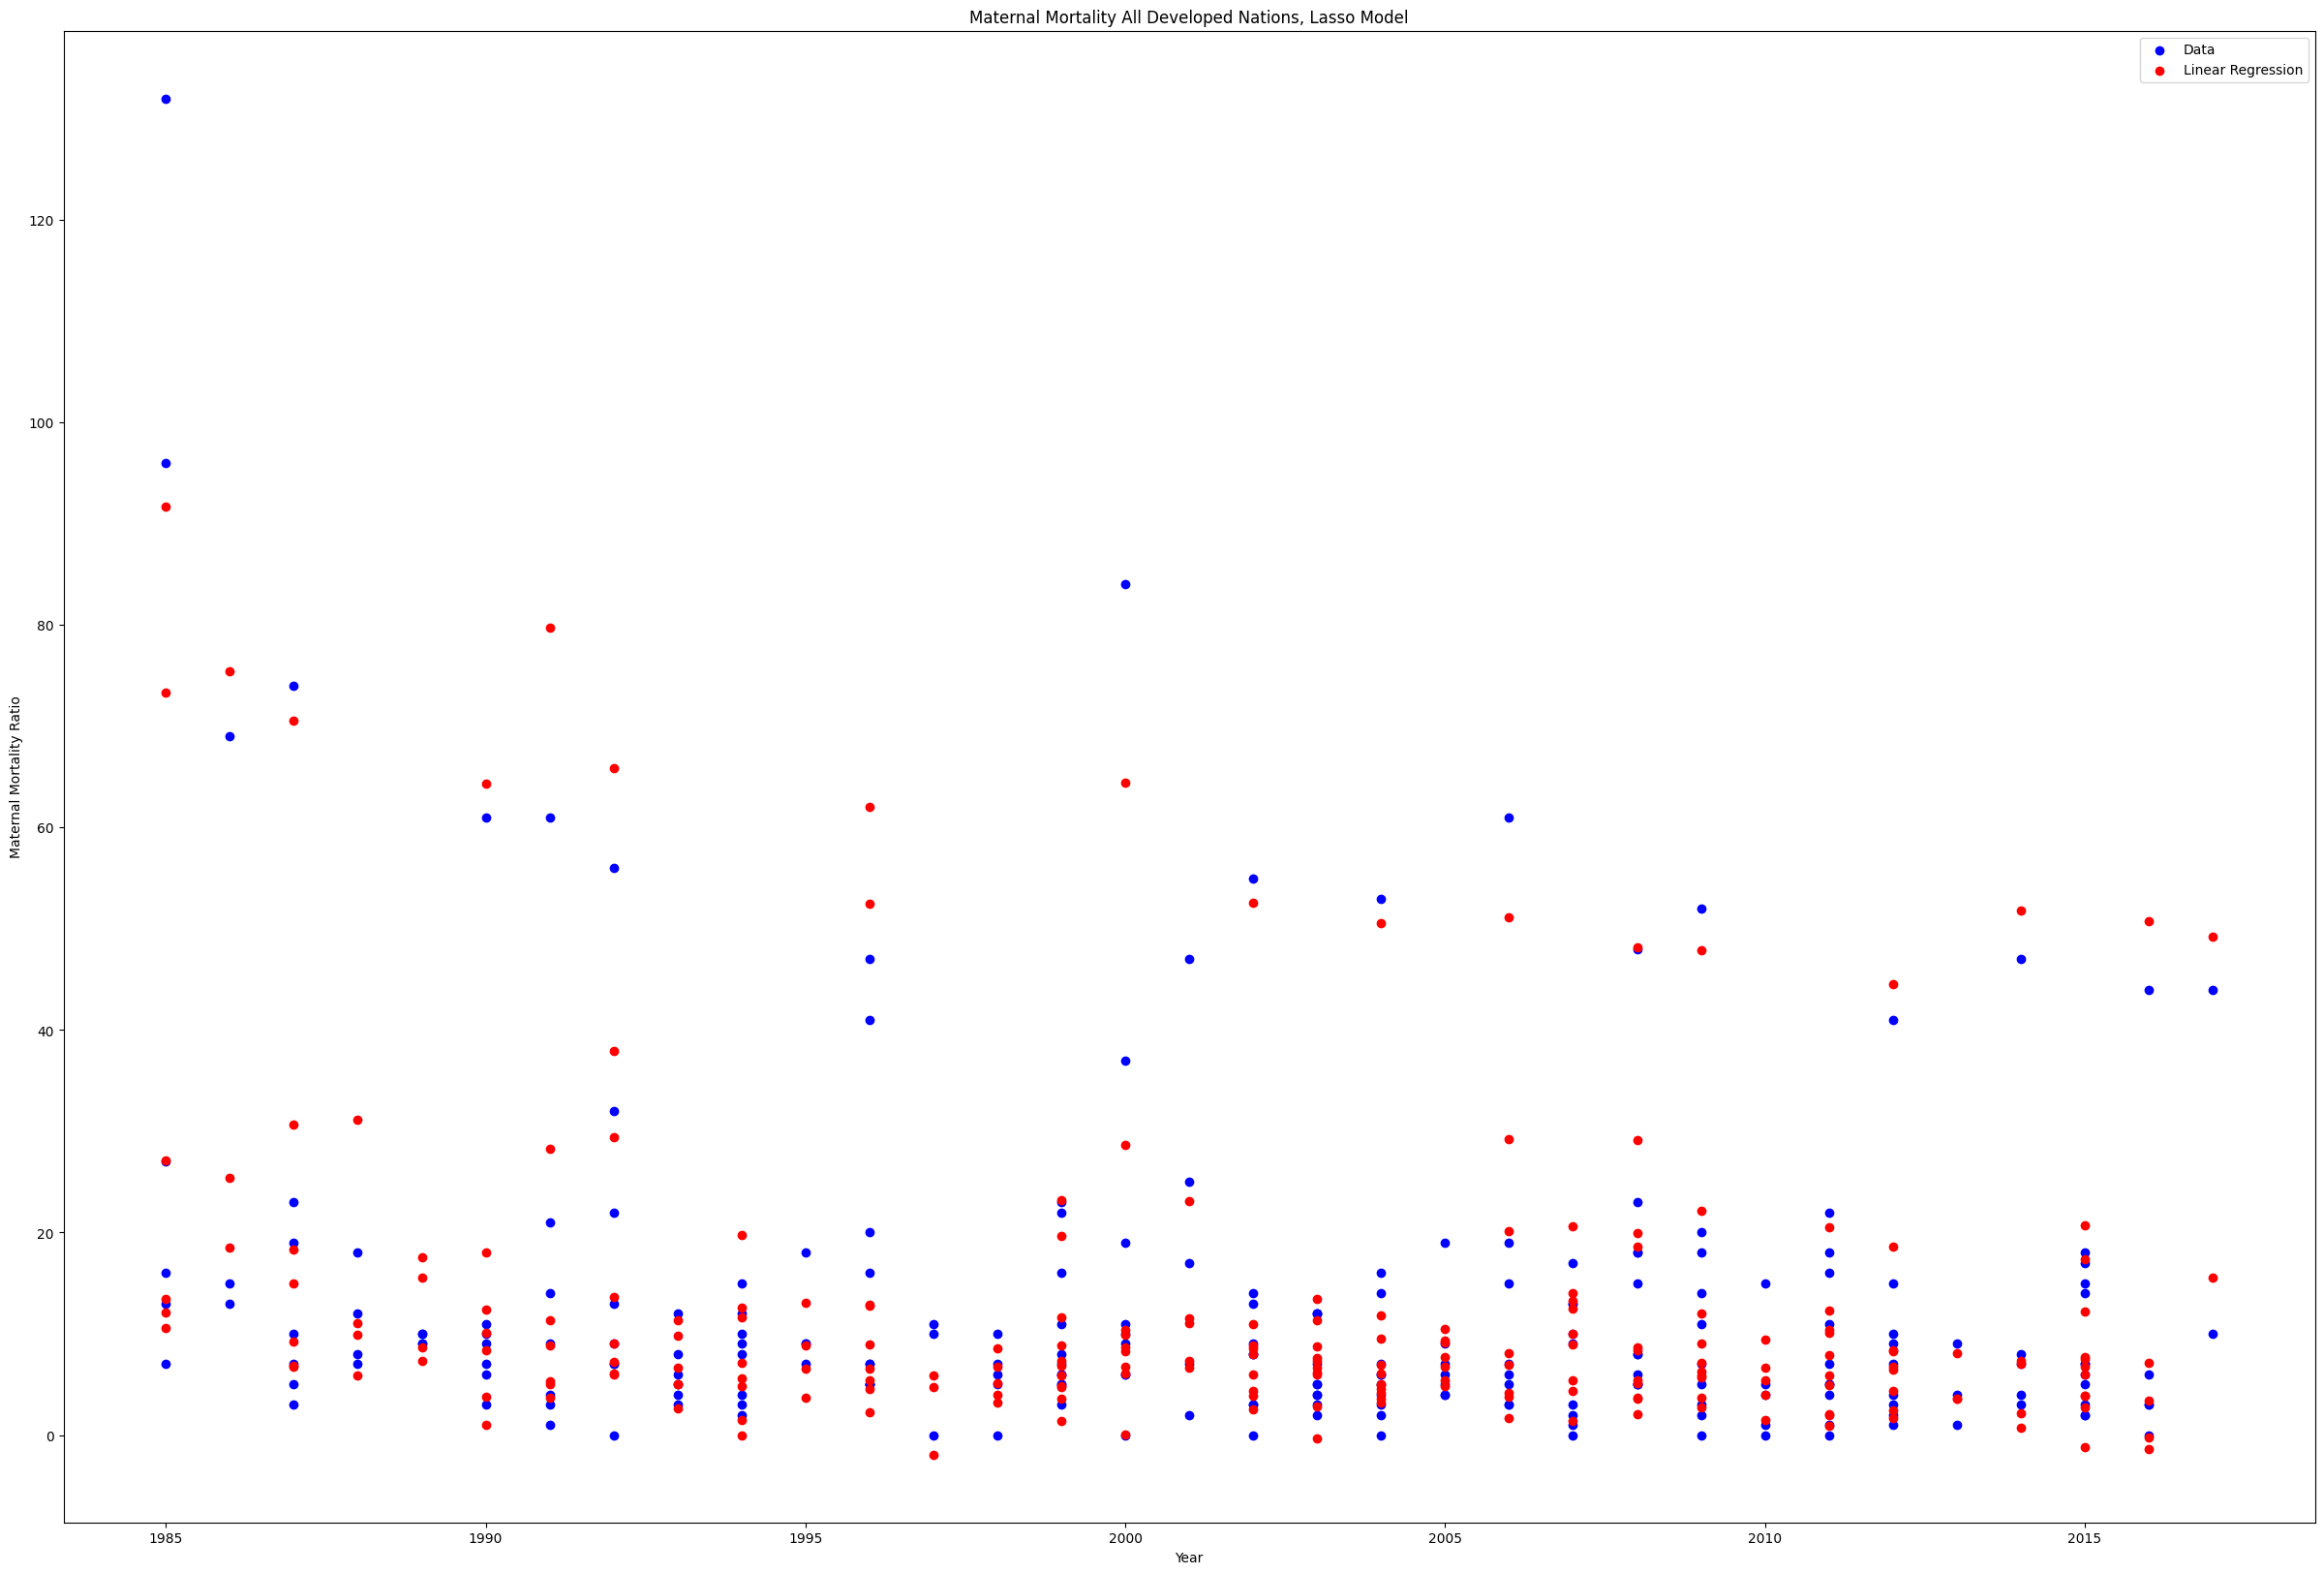

<Figure size 3000x2000 with 0 Axes>

In [279]:
# Make predictions on the test data for Lasso Model
y_pred_lasso = best_lasso_model.predict(X_test)

plot_linear_reg(
    X_test,
    y_test,
    y_pred_lasso,
    country=None,
    title="Maternal Mortality All Developed Nations, Lasso Model",
)

In [280]:
# plot_linear_reg(X_test, y_test, y_pred, country = ['USA'], title = 'Maternal Mortality Predictions USA')

In [281]:
# plot_linear_reg(X_test, y_test, y_pred, country = ['DEU'], title = 'Maternal Mortality Predictions Germany')

In [282]:
# plot_linear_reg(X_test, y_test, y_pred, country = ['DEU', 'USA'], title = 'Maternal Mortality Predictions USA + Germany')

## Shapley Values for Lasso Model

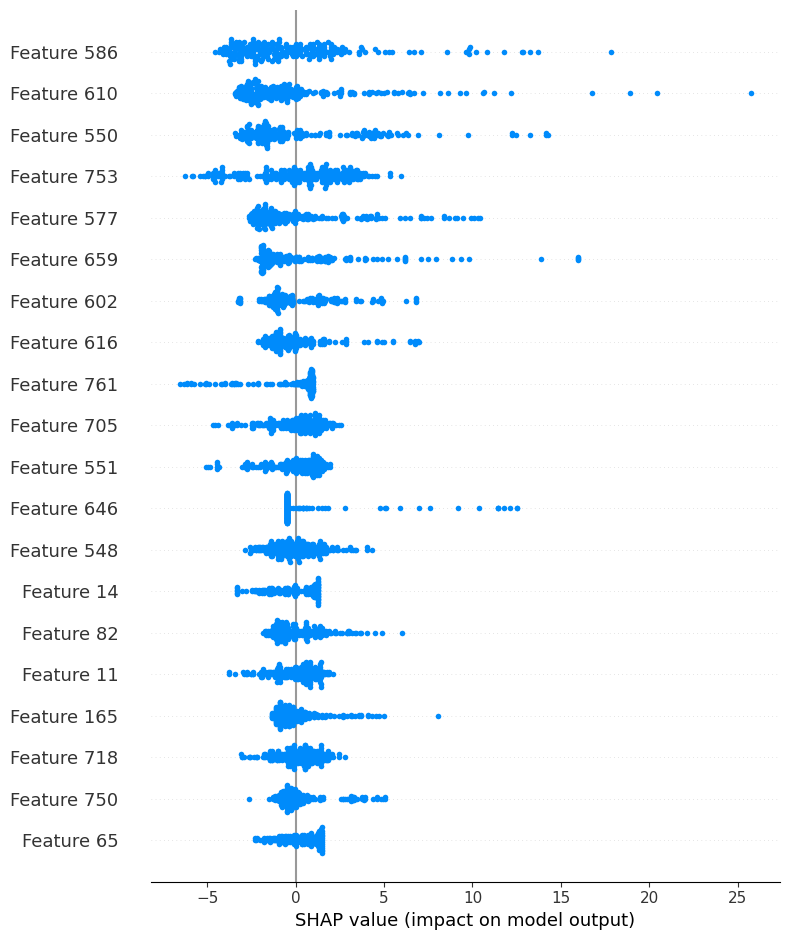

In [283]:
explainer = shap.LinearExplainer(best_lasso_model, X_train)

# look at the features for all instances
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values)

# shap_values.shape

In [284]:
# mapping dataframe for OECD
# mapping_df = mapping_oecd_to_names_and_additional_info_df

# mapping dataframe for World Bank
mapping_df = mapping_world_bank_to_names_and_definitions_df

In [285]:
# Convert the Shapley values and the feature names into a DataFrame
shap_df = pd.DataFrame(data=shap_values, columns=X_test.columns)

# Pull the top shapley features
top_features = shap_df.iloc[0, :].sort_values(ascending=False)
top_feature_names = top_features.index

# Display the top 10 features
# top_feature_names[:10]

# mapping top feature names with code only to their actual feature names
top_feature_names_with_full_name = [
    get_indicator_name_from_code(code, mapping_df) for code in top_feature_names
]

# Display the top 10 features with full name
top_feature_names_with_full_name[:10]

['Employers, female (% of female employment) (modeled ILO estimate)',
 'Current education expenditure, primary (% of total expenditure in primary public institutions)',
 'Fertility rate, total (births per woman)',
 'Pupil-teacher ratio, secondary',
 'Gross enrolment ratio, primary and secondary, both sexes (%)',
 'Educational attainment, at least completed lower secondary, population 25+, female (%) (cumulative)',
 'Official entrance age to upper secondary education (years)',
 'School enrollment, preprimary (% gross)',
 'Survival to age 65, male (% of cohort)',
 'Poverty headcount ratio at $6.85 a day (2017 PPP) (% of population)']

In [286]:
# look at the features for the USA predictions
encoded_values = country_encoder.transform(["USA"])

condition = X_test["Country"].isin(encoded_values)
X_country_lens = X_test[condition]["Year"]

shap_values = explainer.shap_values(X_test.loc[X_country_lens.index])
# shap.summary_plot(shap_values)

### A look at coefficients for lasso model

In [287]:
# Modify this block based on whether you want to use the OECD or World Bank data

# mapping dataframe for OECD
# mapping_df = mapping_oecd_to_names_and_additional_info_df

# mapping dataframe for World Bank
mapping_df = mapping_world_bank_to_names_and_definitions_df

In [288]:
# Get the coefficients and feature names
coefficients = best_lasso_model.coef_
feature_names = X.columns

# Create a dictionary with feature names and their coefficients
coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the features by their absolute coefficients in descending order
sorted_features = sorted(
    coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True
)

# Print the top 10 sorted features
for feature_code, coefficient in sorted_features[0:11]:
    feature_name = get_indicator_name_from_code(feature_code, mapping_df)
    # print(f"{feature_code} {coefficient}")
    print(f"{feature_name}, coefficient: {coefficient}")

Mortality rate, under-5, female (per 1,000 live births), coefficient: 30.765717435971506
Fertility rate, total (births per woman), coefficient: 23.837241853504107
Incidence of tuberculosis (per 100,000 people), coefficient: 19.357906696955986
Own-account workers, female (% of female employment) (modeled ILO estimate), coefficient: 18.96569254042032
People practicing open defecation (% of population), coefficient: 13.784066322811725
Adolescent fertility rate (births per 1,000 women ages 15-19), coefficient: 13.334502266058152
Proportion of people living below 50 percent of median income (%), coefficient: -12.88502453625779
Prevalence of anemia among children (% of children ages 6-59 months), coefficient: 10.129305625376274
Probability of dying among children ages 5-9 years (per 1,000), coefficient: 9.864181744780707
Stillbirth rate (per 1,000 total births), coefficient: 9.705940369860402
Income share held by fourth 20%, coefficient: -8.560237170417953
